In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import seaborn
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline
%config IPCompleter.greedy=True

N_JOBS = 10

In [2]:
df = pd.read_csv('datasets/br/OffComBR2.arff.data', delimiter=';', names=['class', 'text'])

In [3]:
df.describe()

class
count  1250.000000
mean      0.335200
std       0.472249
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [4]:
df.head()

class                                               text
0      1               Votaram no PEZAO Agora tomem no CZAO
1      0  cuidado com a poupanca pessoal Lembram o que a...
2      0  Sabe o que eu acho engracado os nossos governa...
3      1  os cariocas tem o que merecem um pessoal que s...
4      0              Podiam retirar dos lucros dos bancos

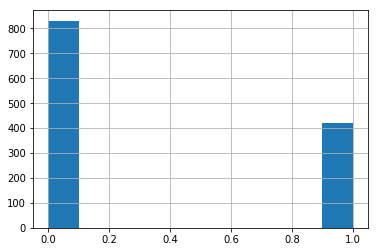

In [5]:
df['class'].hist();

In [6]:
df['class'][df['class']==1].shape

(419,)

# Replicação dos resultados
- Trabalho: Offensive Comments in the Brazilian Web: a dataset and baseline results

In [7]:
# stopwords = nltk.corpus.stopwords.words("portuguese")

DATA_FRAMES = {}

# parametros para construcao dos testes
params = (
    (False, 1, False, 'original_1G'),
    (False, 1, True, 'original_1G_FS'),
    (False, 2, False, 'original_1G_2G'),
    (False, 1, True, 'original_1G_2G_FS'),
    (False, 3, False, 'original_1G_2G_3G'),
    (False, 3, True, 'original_1G_2G_3G_FS'),
    (True, 1, False, 'lower_1G'),
    (True, 1, True, 'lower_1G_FS'),
    (True, 2, False, 'lower_1G_2G'),
    (True, 2, True, 'lower_1G_2G_FS'),
    (True, 3, False, 'lower_1G_2G_3G'),
    (True, 3, True, 'lower_1G_2G_3G_FS')
)

# quando use_fs é True
tree = DecisionTreeClassifier()

for is_lower, ngram_max, use_fs, df_name in params:
    vec = CountVectorizer(lowercase=is_lower, ngram_range=(1,ngram_max), token_pattern=r'(?u)\b\w+\b')
    matrix = vec.fit_transform(df['text'])
    names = np.array(vec.get_feature_names())
    dataframe = pd.DataFrame(matrix.toarray(), columns=names)
    
    if use_fs:
        sel = SelectFromModel(tree)
        fs = sel.fit_transform(dataframe, df['class'])
        indices = sel.get_support(True)
        
        dataframe = pd.DataFrame(fs, columns=names[indices])
        DATA_FRAMES[df_name] = dataframe
        
    else:
        DATA_FRAMES[df_name] = dataframe
        
        
    print(df_name, ' - ', dataframe.shape)
    

original_1G  -  (1250, 4979)
original_1G_FS  -  (1250, 266)
original_1G_2G  -  (1250, 17373)
original_1G_2G_FS  -  (1250, 262)
original_1G_2G_3G  -  (1250, 30710)
original_1G_2G_3G_FS  -  (1250, 262)
lower_1G  -  (1250, 4122)
lower_1G_FS  -  (1250, 252)
lower_1G_2G  -  (1250, 15898)
lower_1G_2G_FS  -  (1250, 255)
lower_1G_2G_3G  -  (1250, 29125)
lower_1G_2G_3G_FS  -  (1250, 272)


In [8]:
DATA_FRAMES['original_1G'].head()

A  ABAIXO  ACEFALA  ACEFALOSESTE  ACEITAREMOS  ACHAR  ACHO  ACOMODOU  \
0  0       0        0             0            0      0     0         0   
1  0       0        0             0            0      0     0         0   
2  0       0        0             0            0      0     0         0   
3  0       0        0             0            0      0     0         0   
4  0       0        0             0            0      0     0         0   

   ACORDA  ADESTRADOJOGA  ...   zeras  zero  zes  zika  zologico  zombe  zona  \
0       0              0  ...       0     0    0     0         0      0     0   
1       0              0  ...       0     0    0     0         0      0     0   
2       0              0  ...       0     0    0     0         0      0     0   
3       0              0  ...       0     0    0     0         0      0     0   
4       0              0  ...       0     0    0     0         0      0     0   

   zozoi  zuados  zuar  
0      0       0     0  
1      0       0     0  
2      0       0     0  
3      0       0     0  
4      0       0     0  

[5 rows x 4979 columns]

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, random_state=1)

y = df['class'].astype(float)

In [10]:
print('SVM=dict(')
svm = SVC(kernel='linear', C=1)

for name, x in DATA_FRAMES.items():
    f1 = cross_val_score(svm, x, y, cv=cv, scoring='f1_weighted', n_jobs=N_JOBS)
    print(f'{name}={list(f1)},')
print(')')


print('NB=dict(')
nb = GaussianNB()

for name, x in DATA_FRAMES.items():
    f1 = cross_val_score(nb, x, y, cv=cv, scoring='f1_weighted',  n_jobs=N_JOBS)
    print(f'{name}={list(f1)},')
print(')')

SVM=dict(
original_1G=[0.7478952420128891, 0.627027195027195, 0.7243129788716044, 0.5883187429854096, 0.6674882154882155, 0.6305318352059925, 0.7191515763653417, 0.6801303205465056, 0.6896100178890877, 0.6371384861015922],
original_1G_FS=[0.711111111111111, 0.6230927835051546, 0.6544, 0.756411067193676, 0.7354032258064516, 0.6840912803266875, 0.8132444444444444, 0.6732607709750567, 0.7423600713012477, 0.6871636302858097],
original_1G_2G=[0.7291666666666665, 0.6073970473970475, 0.7216126482213439, 0.6091180035650624, 0.6433411764705883, 0.6137378277153559, 0.7352000577158936, 0.7207985739750445, 0.6428940131161414, 0.6238845910572666],
original_1G_2G_FS=[0.6947250280583616, 0.629942528735632, 0.6842501517911352, 0.7453333333333334, 0.7523958683641606, 0.617982174688057, 0.8058364938232748, 0.6669482758620691, 0.7203358487292912, 0.6872436319440928],
original_1G_2G_3G=[0.7403084141561526, 0.6327780076854863, 0.7423141564318035, 0.6688371685294763, 0.6365285996055227, 0.6442057142857143, 